# Credit Card Fraud Detection

## Contents

1. [Introduction](#Introduction)
2. [Import libraries and data](#Import-libraries-and-data)
3. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
4. [Data preprocessing](#Data-Preprocessing)
5. [Feature selection](#Feature-selection)
6. [Model building](#Model-building)
7. [Hyperparameter tuning](#Hyperparameter-tuning)
   - 7.1 [Randomized Search](#Randomized-Search)
   - 7.2 [Optuna](#Optuna)
8. [Model evaluation](#Model-evaluation)
9. [Conclusion](#Conclusion)


## Introduction
With the rise of credit card related fraud, fraud detection has become a critical concern for both consumers and institutions. Using ML algorithms, we can effectively identify and prevent fraudulent transactions, ensuring utmost security. This notebook demonstrates the process of developing and evaluating a machine learning model for credit card fraud detection. The goal is to build a robust model that can accurately identify fraudulent transactions, minimizing financial losses and enhancing the security of credit card transactions.

The evalution will be done based on **F1 score for the fraudulent class** since it is a sweet spot between precision and recall. It is again very important to increase the recall value for fraudulent transactions since a fraud is what we want to identify with all the confidence we can, while also not flagging too many legitimate transactions as fradulent since that would only cause innconvenience to the customer. 

## Import libraries and data

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from sklearn.metrics import make_scorer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

data = pd.read_csv('creditcard.csv')

## Exploratory Data Analysis (EDA)

In [2]:
data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [3]:
data.shape

(284807, 31)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
data.isnull().sum().sum()

0

In [6]:
fraud = data[data['Class'] == 1]
legit = data[data['Class'] == 0]

Let's check how the Amount of the transactions vary for both the target classes with time

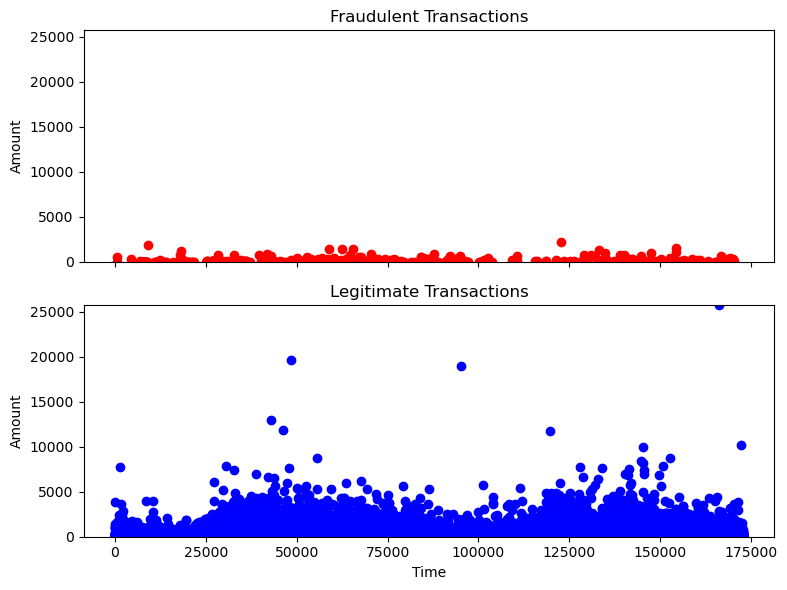

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax1.scatter(fraud['Time'], fraud['Amount'], color='red', marker='o')
ax1.set_ylabel('Amount')
ax1.set_title('Fraudulent Transactions')
ax1.set_ylim(0, max(fraud['Amount'].max(), legit['Amount'].max()))

ax2.scatter(legit['Time'], legit['Amount'], color='blue', marker='o')
ax2.set_xlabel('Time')
ax2.set_ylabel('Amount')
ax2.set_title('Legitimate Transactions')
ax2.set_ylim(0, max(fraud['Amount'].max(), legit['Amount'].max()))

plt.tight_layout()
plt.show()

It can be seen that the amount for fraudulant transactions is always within a low range of $2100

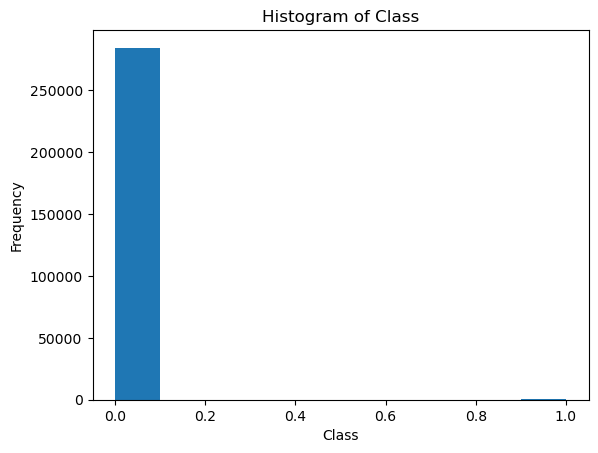

In [8]:
# Lets see the output variable disribution
plt.hist(data['Class'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Histogram of Class')
plt.show()

In [9]:
data['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

It looks like a highly unbalanced dataset

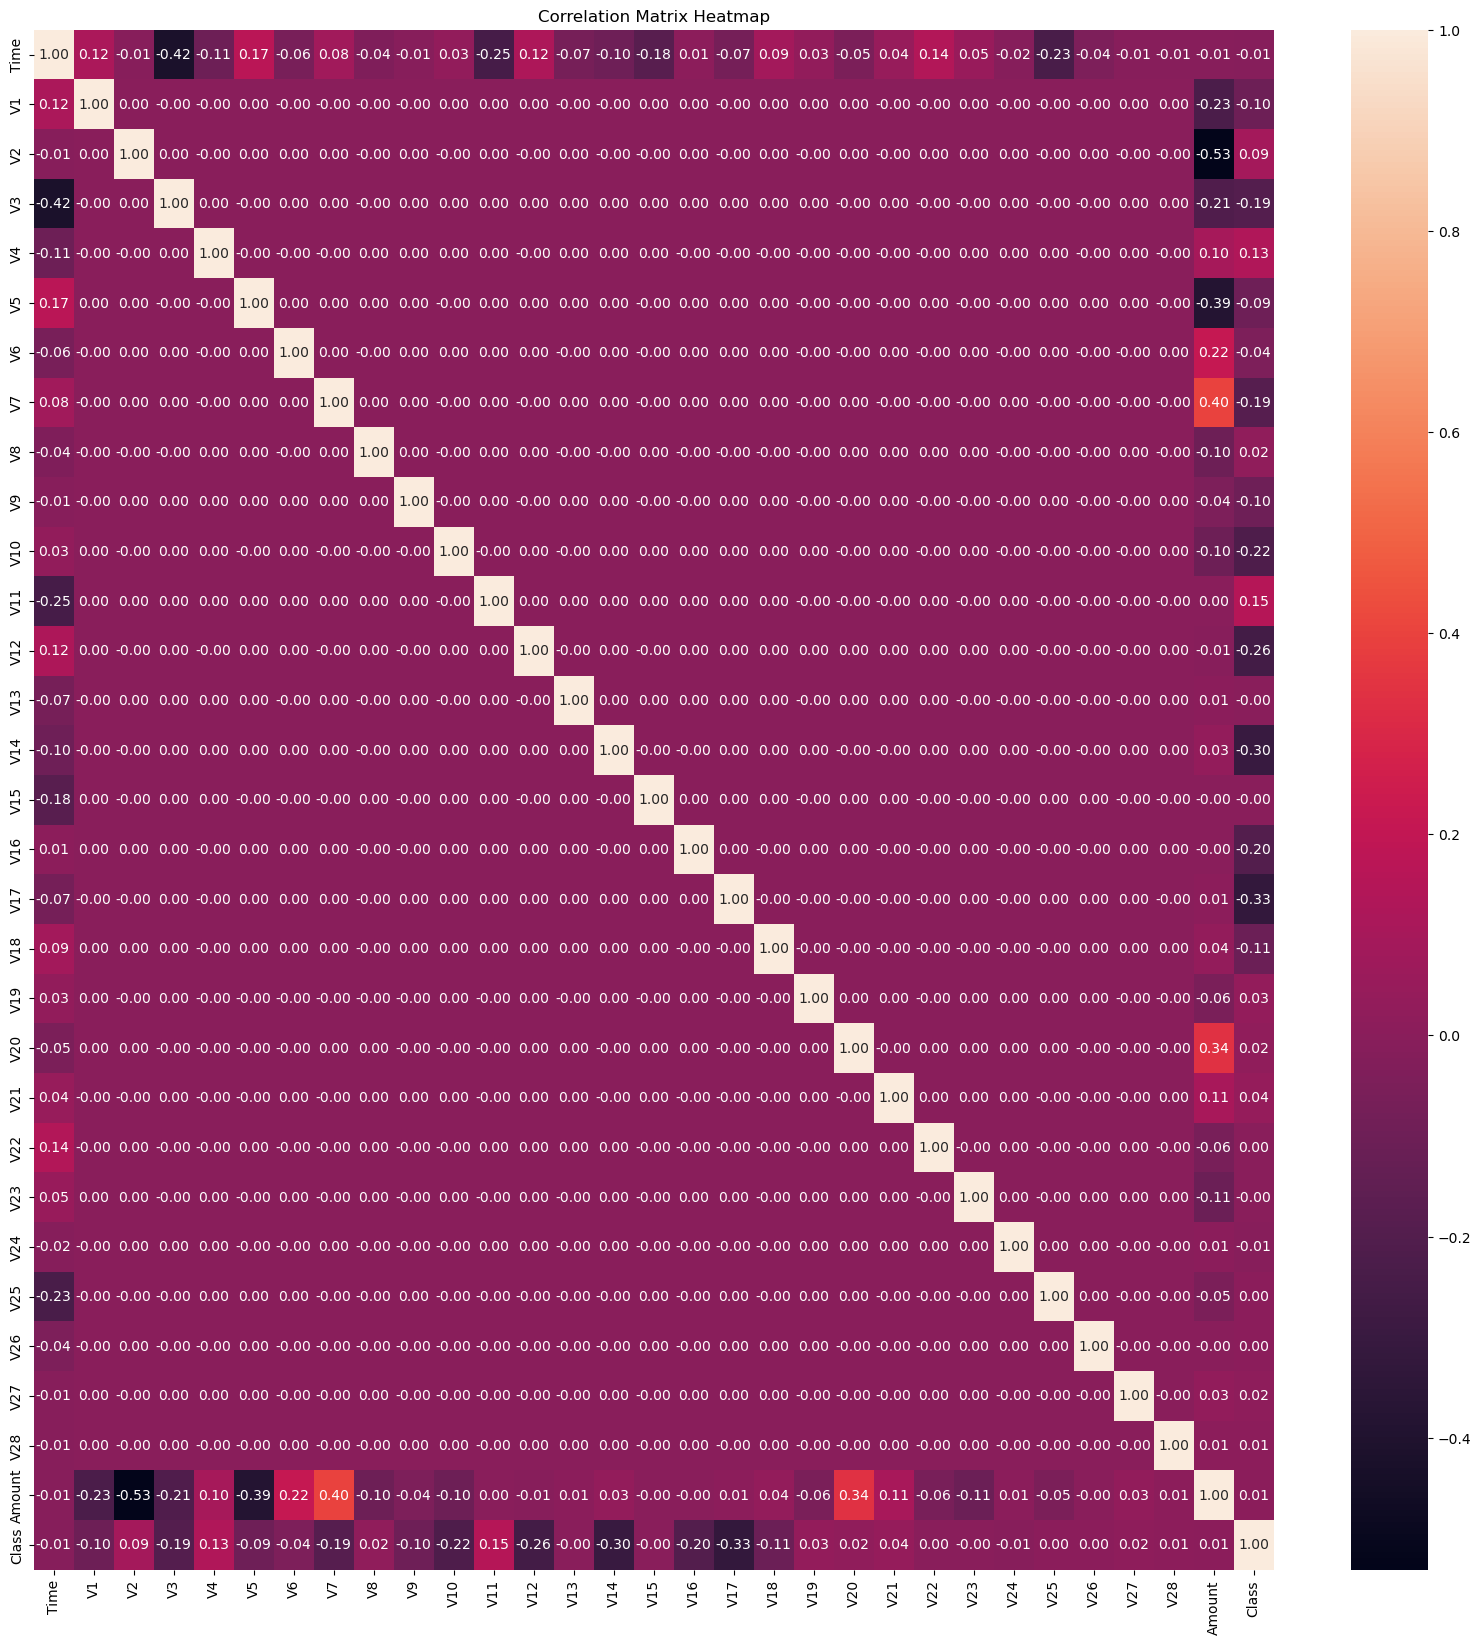

In [10]:
# Lets check for correlations
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot = True,  fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

There seems to be no correlation amongst the predictors. This occurs since the data is already PCA transformed. We shall focus on features that have some correlation with the target variable.

## Data Preprocessing

In [11]:
# Removing the 'Time' column as it is not required
data = data.drop('Time',axis=1)

In [12]:
# Removing duplicate values
data = data.drop_duplicates()

In [13]:
data['Class'].value_counts()

Class
0    275190
1       473
Name: count, dtype: int64

In [14]:
# The amount column must be standardized
sc = StandardScaler()
data['Amount'] = sc.fit_transform(pd.DataFrame(data['Amount']))
data.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.098698  0.363787  0.090794  ... -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425 -0.166974  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  0.207643  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024 -0.054952  ... -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  0.753074  ... -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28    Amount  Class  
0  0.128539 -0.189115  0.133558 -0.021053  0.233169      0  
1  0.167170  0.125895 -0.008983  0.014724 -0.347092      0  
2 -0.327642 -0.139097 -0.055353 -0.059752  1.137702      0  
3  0.647376 -0.221929  0.062723  0.061458  0.130015      0  
4 -0.206010  0.502292  0.219422  0.215153 -0.081308      0  

[5 rows x 30 columns]

In [15]:
# Creating backup of orignal data
data_OG = data.copy()

In [16]:
X = data.drop('Class', axis = 1)
y = data['Class']

In [17]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Creating Oversampled dataset to tackle imbalance

In [18]:
# Oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

## Feature selection

Lets figure out if there are features that need to be removed. For this we shall first try fitting the oversampled data on 2 algorithms, random forest and xgboost. We shall check the performance metrics and then see the feature importances.

In [19]:
# Using feature importances from Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_os, y_train_os)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9993470335370831
Precision: 0.8390804597701149
Recall: 0.7684210526315789
F1 Score: 0.8021978021978022


In [20]:
importances = clf.feature_importances_
importances

array([0.01126342, 0.02092252, 0.03288994, 0.12179963, 0.01083228,
       0.00698455, 0.04694404, 0.01362628, 0.01261636, 0.15154742,
       0.10031153, 0.10180632, 0.00690952, 0.14115981, 0.00779087,
       0.0510893 , 0.05837218, 0.01335414, 0.00854789, 0.00776757,
       0.01468089, 0.00510241, 0.00796011, 0.00383396, 0.00564776,
       0.00812442, 0.00838143, 0.00814233, 0.01159109])

<function matplotlib.pyplot.show(close=None, block=None)>

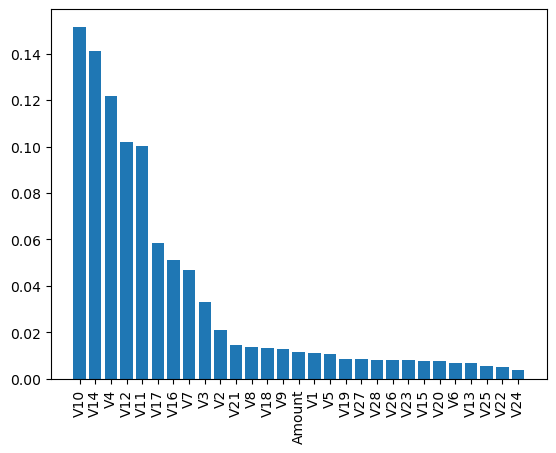

In [21]:
plt.bar(range(len(importances)), importances[np.argsort(importances)[::-1]])
plt.xticks(range(len(importances)), X_train.columns[np.argsort(importances)[::-1]], rotation='vertical')
plt.show

From here, we can see that V10, V14, V4, V12, V11 seem important to the random forest algorithm.

In [22]:
# Repeating the same process with XGBoost Classifier
clf2 = XGBClassifier(random_state=42)
clf2.fit(X_train_os, y_train_os)
y_pred = clf2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9991837919213539
Precision: 0.75
Recall: 0.7894736842105263
F1 Score: 0.7692307692307693


<function matplotlib.pyplot.show(close=None, block=None)>

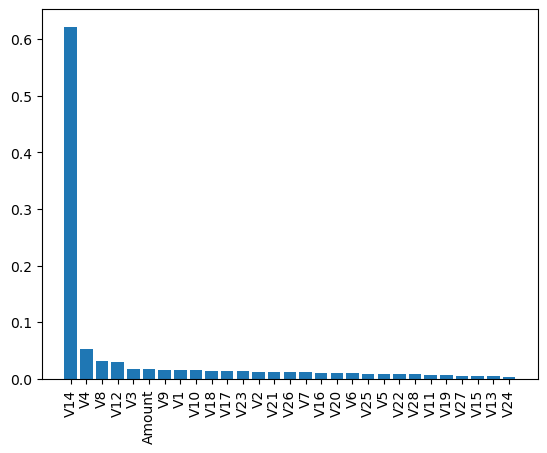

In [23]:
importances = clf2.feature_importances_
importances

plt.bar(range(len(importances)), importances[np.argsort(importances)[::-1]])
plt.xticks(range(len(importances)), X_train.columns[np.argsort(importances)[::-1]], rotation='vertical')
plt.show

Here we get a very disproportionate set of importances. They are V14, V4, V8, V12, V3 and Amount

Lets select the best promising features from both and then train a model. Selecting features V3, V4, V8, V10, V11, V12, V14 and Amount V17, V16, V7, V3 V2

In [24]:
data_set_1 = data[['V2','V3', 'V4', 'V5', 'V7', 'V8', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V20', 'Amount','Class']]

In [25]:
data_set_1.head()

V2        V3        V4        V5        V7        V8       V10  \
0 -0.072781  2.536347  1.378155 -0.338321  0.239599  0.098698  0.090794   
1  0.266151  0.166480  0.448154  0.060018 -0.078803  0.085102 -0.166974   
2 -1.340163  1.773209  0.379780 -0.503198  0.791461  0.247676  0.207643   
3 -0.185226  1.792993 -0.863291 -0.010309  0.237609  0.377436 -0.054952   
4  0.877737  1.548718  0.403034 -0.407193  0.592941 -0.270533  0.753074   

        V11       V12       V14       V16       V17       V20    Amount  Class  
0 -0.551600 -0.617801 -0.311169 -0.470401  0.207971  0.251412  0.233169      0  
1  1.612727  1.065235 -0.143772  0.463917 -0.114805 -0.069083 -0.347092      0  
2  0.624501  0.066084 -0.165946 -2.890083  1.109969  0.524980  1.137702      0  
3 -0.226487  0.178228 -0.287924 -1.059647 -0.684093 -0.208038  0.130015      0  
4 -0.822843  0.538196 -1.119670 -0.451449 -0.237033  0.408542 -0.081308      0

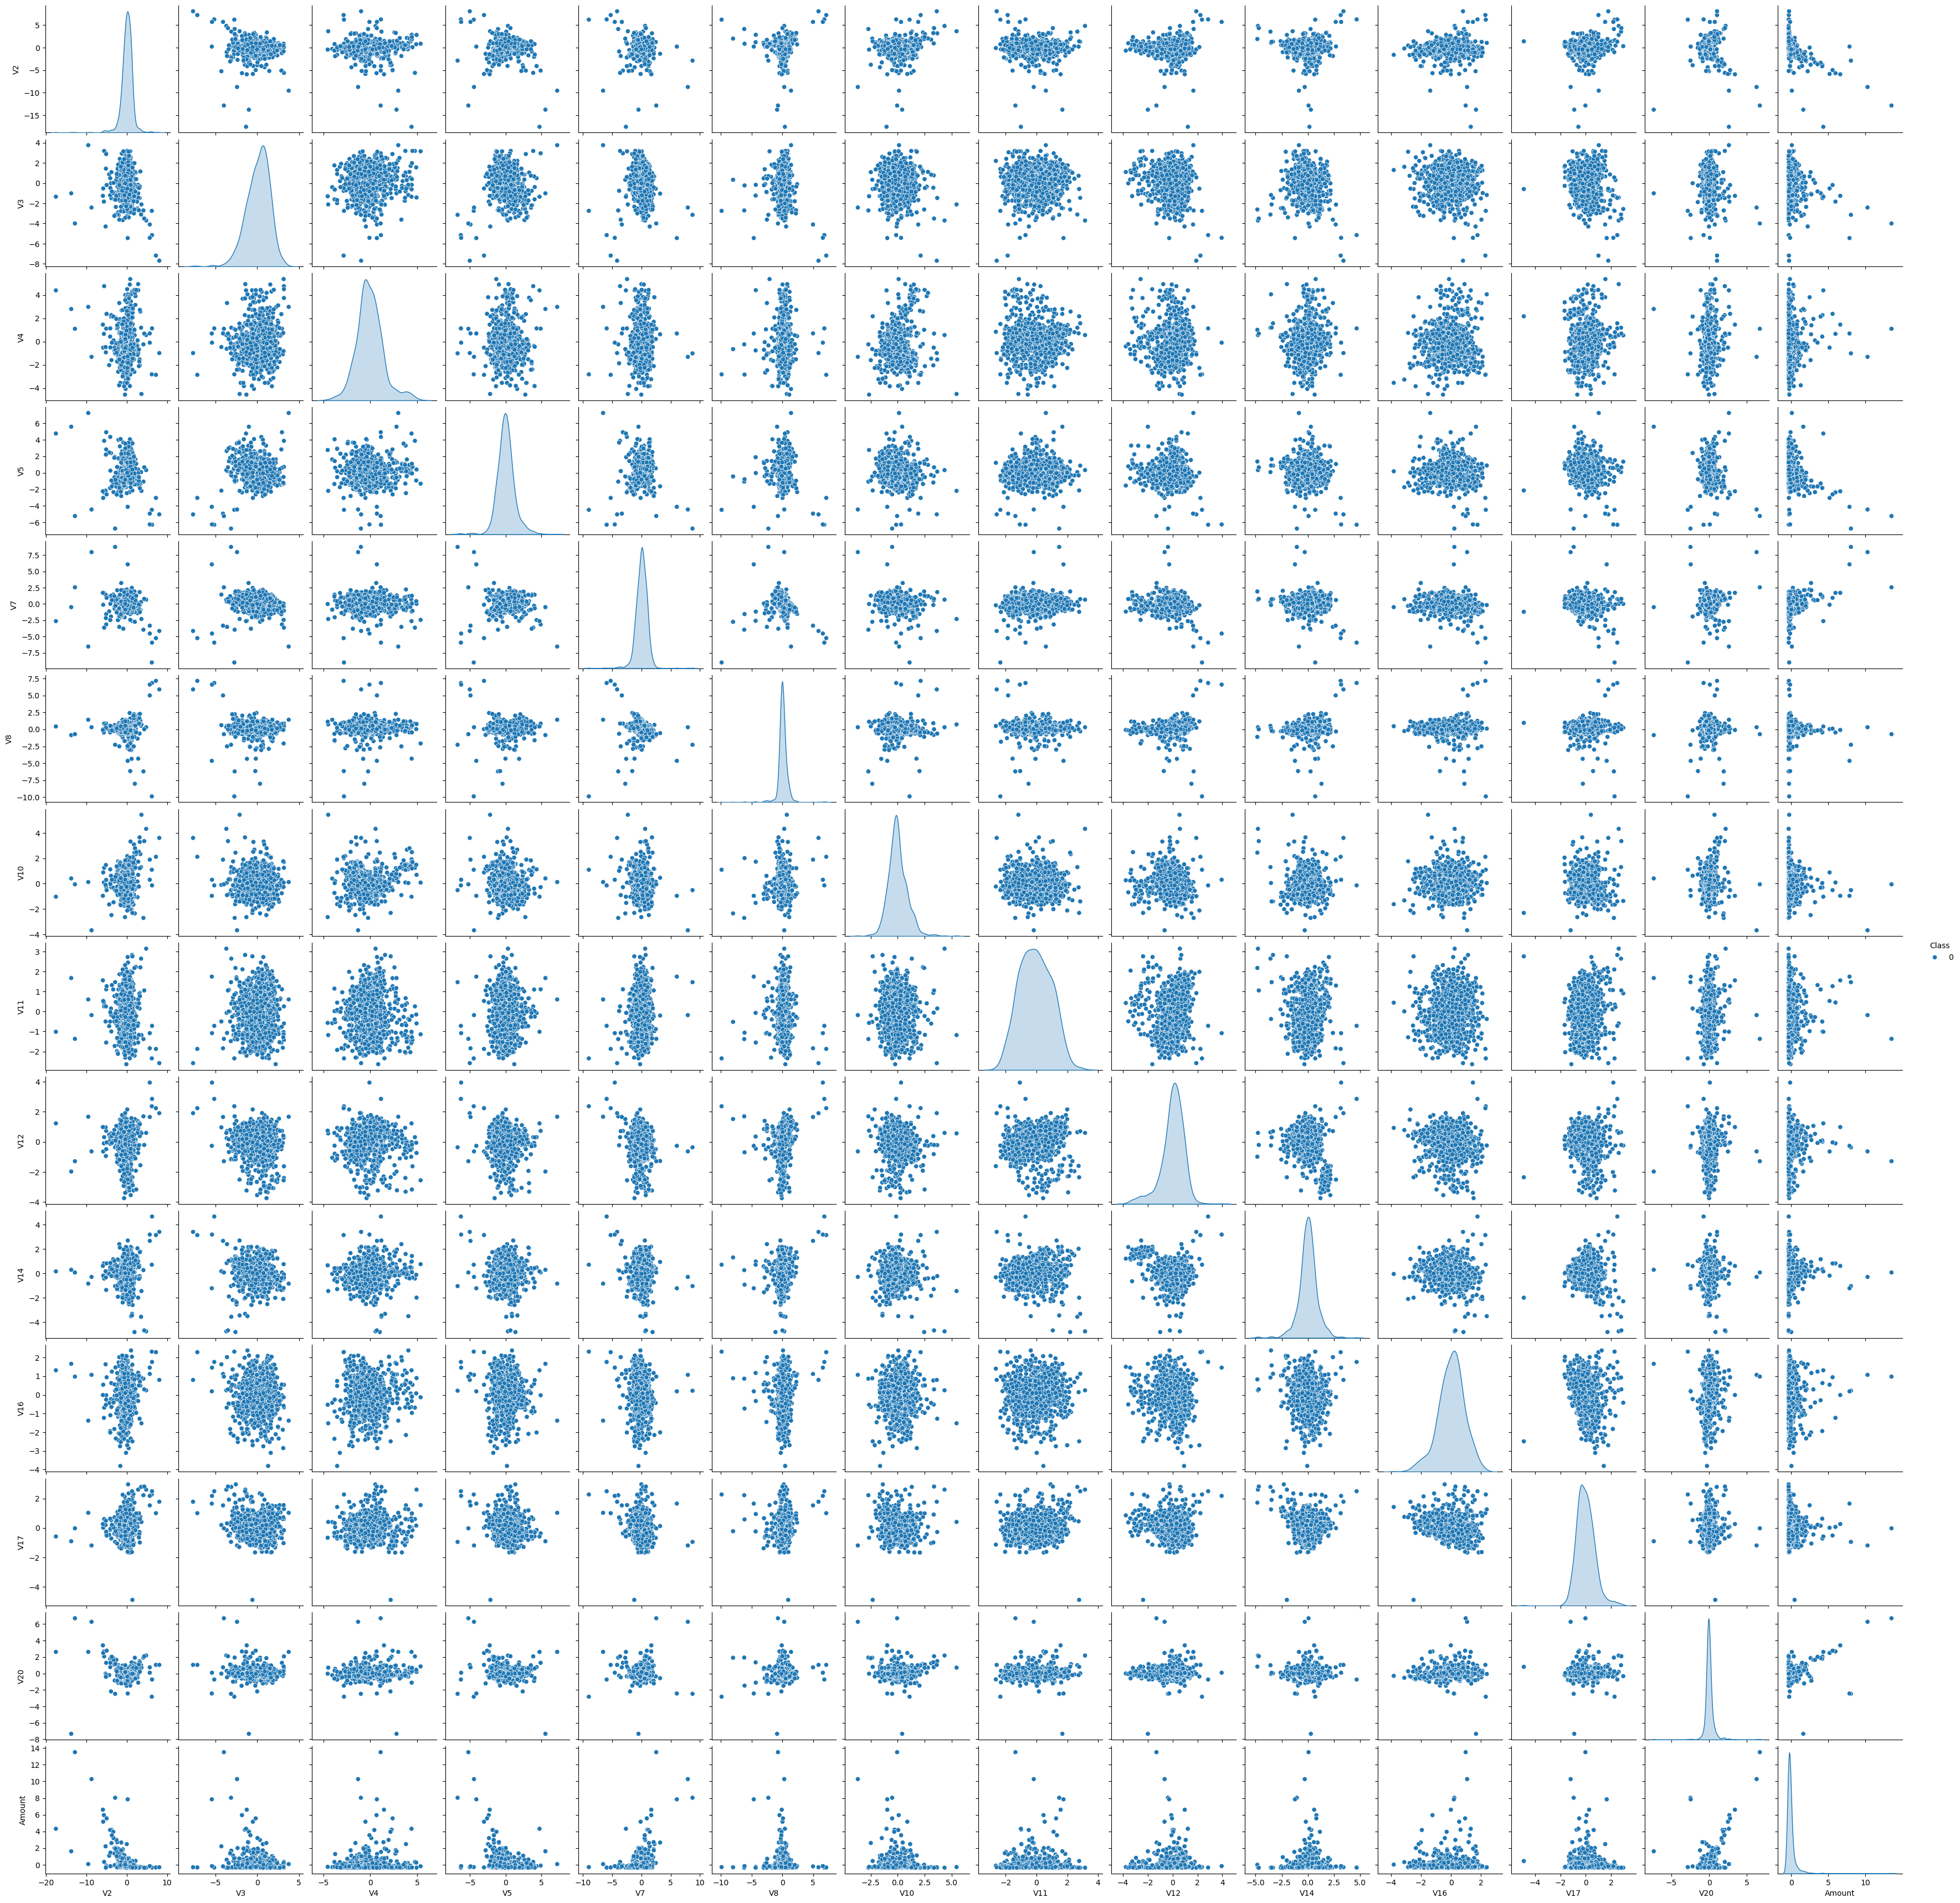

In [26]:
sns.pairplot(data_set_1.sample(1000), hue = 'Class')

In [27]:
# Repeating the process to run new dataset on different algorithms to compare performance before and after dropping the less important features

X = data_set_1.drop('Class', axis = 1)
y = data_set_1['Class']

 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_os, y_train_os)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9992926196651734
Precision: 0.7857142857142857
Recall: 0.8105263157894737
F1 Score: 0.7979274611398963


Since here the recall value is higher, we shall go with this dataset with selected features

## Model building

Now we shall find the best algorithm amongst the following:
- Random Forest
- XGBoost
- KNearest Neighbours 
- Gradient Boost
- AdaBoostClassifier
- DBSCAN
- LocalOutlierFactor
- IsolationForest

We shall create a loop over a list of classifiers and then iterate over that loop. Each time the loop runs for an algorithm, the results for that alorithm will be stored in a dataframe

In [28]:

results = pd.DataFrame(columns = ['Model','Dataset','Accuracy', 'Precision','Recall', 'F1'])

classifiers = [
    RandomForestClassifier(),
    XGBClassifier(),
    KNeighborsClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier()
]

# Iterate over each classifier
for clf in classifiers:
    clf_name = clf.__class__.__name__
    
    clf.fit(X_train_os, y_train_os)
    y_pred = clf.predict(X_test)
 
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    list = [clf_name,'Over_sampled_Features', accuracy, precision, recall, f1]

    results = pd.concat([results, pd.DataFrame([list], columns = results.columns)], ignore_index=True)
    
results

C:\Users\Admin\AppData\Local\Temp\ipykernel_21364\784935418.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([list], columns = results.columns)], ignore_index=True)
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model                Dataset  Accuracy  Precision  \
0      RandomForestClassifier  Over_sampled_Features  0.999383   0.835165   
1               XGBClassifier  Over_sampled_Features  0.998712   0.592308   
2        KNeighborsClassifier  Over_sampled_Features  0.996917   0.336245   
3  GradientBoostingClassifier  Over_sampled_Features  0.988301   0.116992   
4          AdaBoostClassifier  Over_sampled_Features  0.977055   0.062780   

     Recall        F1  
0  0.800000  0.817204  
1  0.810526  0.684444  
2  0.810526  0.475309  
3  0.884211  0.206642  
4  0.884211  0.117237

Doing the same thing with all the features of the orignal data

In [29]:
X = data_OG.drop('Class', axis = 1)
y = data_OG['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

classifiers = [
    RandomForestClassifier(),
    XGBClassifier(),
    KNeighborsClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier()
]

# Iterate over each classifier
for clf in classifiers:
    clf_name = clf.__class__.__name__
    
    clf.fit(X_train, y_train)    
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    list = [clf_name,'All_Features_original', accuracy, precision, recall, f1]

    results = pd.concat([results, pd.DataFrame([list], columns = results.columns)], ignore_index=True)
    
results

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model                Dataset  Accuracy  Precision  \
0      RandomForestClassifier  Over_sampled_Features  0.999383   0.835165   
1               XGBClassifier  Over_sampled_Features  0.998712   0.592308   
2        KNeighborsClassifier  Over_sampled_Features  0.996917   0.336245   
3  GradientBoostingClassifier  Over_sampled_Features  0.988301   0.116992   
4          AdaBoostClassifier  Over_sampled_Features  0.977055   0.062780   
5      RandomForestClassifier  All_Features_original  0.999420   0.920000   
6               XGBClassifier  All_Features_original  0.999420   0.920000   
7        KNeighborsClassifier  All_Features_original  0.999420   0.898734   
8  GradientBoostingClassifier  All_Features_original  0.998912   0.721519   
9          AdaBoostClassifier  All_Features_original  0.999075   0.768293   

     Recall        F1  
0  0.800000  0.817204  
1  0.810526  0.684444  
2  0.810526  0.475309  
3  0.884211  0.206642  
4  0.884211  0.117237  
5  0.726316  0.811765  
6  0.726316  0.811765  
7  0.747368  0.816092  
8  0.600000  0.655172  
9  0.663158  0.711864

Doing the same thing with selected features of the orignal data

In [30]:
X = data_set_1.drop('Class', axis = 1)
y = data_set_1['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

classifiers = [
    RandomForestClassifier(),
    XGBClassifier(),
    KNeighborsClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier()
]

# Iterate over each classifier
for clf in classifiers:
    clf_name = clf.__class__.__name__
    
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    list = [clf_name,'Selected_Features', accuracy, precision, recall, f1]

    results = pd.concat([results, pd.DataFrame([list], columns = results.columns)], ignore_index=True)
    
results

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model                Dataset  Accuracy  Precision  \
0       RandomForestClassifier  Over_sampled_Features  0.999383   0.835165   
1                XGBClassifier  Over_sampled_Features  0.998712   0.592308   
2         KNeighborsClassifier  Over_sampled_Features  0.996917   0.336245   
3   GradientBoostingClassifier  Over_sampled_Features  0.988301   0.116992   
4           AdaBoostClassifier  Over_sampled_Features  0.977055   0.062780   
5       RandomForestClassifier  All_Features_original  0.999420   0.920000   
6                XGBClassifier  All_Features_original  0.999420   0.920000   
7         KNeighborsClassifier  All_Features_original  0.999420   0.898734   
8   GradientBoostingClassifier  All_Features_original  0.998912   0.721519   
9           AdaBoostClassifier  All_Features_original  0.999075   0.768293   
10      RandomForestClassifier      Selected_Features  0.999456   0.945205   
11               XGBClassifier      Selected_Features  0.999474   0.945946   
12        KNeighborsClassifier      Selected_Features  0.999438   0.900000   
13  GradientBoostingClassifier      Selected_Features  0.998948   0.793651   
14          AdaBoostClassifier      Selected_Features  0.999184   0.804878   

      Recall        F1  
0   0.800000  0.817204  
1   0.810526  0.684444  
2   0.810526  0.475309  
3   0.884211  0.206642  
4   0.884211  0.117237  
5   0.726316  0.811765  
6   0.726316  0.811765  
7   0.747368  0.816092  
8   0.600000  0.655172  
9   0.663158  0.711864  
10  0.726316  0.821429  
11  0.736842  0.828402  
12  0.757895  0.822857  
13  0.526316  0.632911  
14  0.694737  0.745763

Now let's see how some outlier detection algorithms work on this problem

### Local Outlier Factor

In [31]:
from sklearn.neighbors import LocalOutlierFactor 

In [32]:
X = data_set_1.drop('Class', axis = 1)
y = data_set_1['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

lof = LocalOutlierFactor(n_neighbors=20, contamination = 0.0017)
y_pred = lof.fit_predict(X_test) 

# Converting y_pred to a format compatible with LOF algorithm The LOF algorithm gives output -1 for outliers and 1 for normal points
y_pred_converted = np.where(y_pred == -1, 1, 0)


accuracy = accuracy_score(y_test, y_pred_converted)
precision = precision_score(y_test, y_pred_converted, pos_label=1, average='binary')
recall = recall_score(y_test, y_pred_converted, pos_label=1, average='binary')
f1 = f1_score(y_test, y_pred_converted, pos_label=1, average='binary')

pd.DataFrame({'y_test':y_test,'y_pred': y_pred_converted,'y_pr':y_pred})

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")  
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

list = ['LocalOutlierFactor','OG_Data', accuracy, precision, recall, f1]
results = pd.concat([results, pd.DataFrame([list], columns = results.columns)], ignore_index=True)

Accuracy: 0.996644477898899
Precision: 0.02127659574468085
Recall: 0.021052631578947368
F1 Score: 0.021164021164021163


As we can see, LOF is performing miseribly. We shall now try isolation forest.

### Isolation Forest

In [33]:
isolation_forest = IsolationForest(contamination=0.01, random_state=42)
isolation_forest.fit(X_train)

# Predicting anomalies in the test set
y_pred = isolation_forest.predict(X_test)
y_pred_converted = np.where(y_pred == -1, 1, 0)

accuracy = accuracy_score(y_test, y_pred_converted)
precision = precision_score(y_test, y_pred_converted, pos_label=1, average='binary')
recall = recall_score(y_test, y_pred_converted, pos_label=1, average='binary')
f1 = f1_score(y_test, y_pred_converted, pos_label=1, average='binary')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

list = ['IsolationForest','OG_Data', accuracy, precision, recall, f1]
results = pd.concat([results, pd.DataFrame([list], columns = results.columns)], ignore_index=True)

Accuracy: 0.9912937804944407
Precision: 0.1276595744680851
Recall: 0.6947368421052632
F1 Score: 0.21568627450980393


Here as we can see, there is no benefit using this algorithm either. Lets now try DBSCAN

In [34]:
dbscan = DBSCAN(eps=0.8, min_samples=15)
y_pred = dbscan.fit_predict(X_test)


y_pred_converted = np.where(y_pred == -1, 1, 0)


accuracy = accuracy_score(y_test, y_pred_converted)
precision = precision_score(y_test, y_pred_converted, pos_label=1, average='binary')
recall = recall_score(y_test, y_pred_converted, pos_label=1, average = 'binary')
f1 = f1_score(y_test, y_pred_converted, pos_label=1, average='binary')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

list = ['DBSCAN','OG_Data', accuracy, precision, recall, f1]
results = pd.concat([results, pd.DataFrame([list], columns = results.columns)], ignore_index=True)

Accuracy: 0.42968820851395717
Precision: 0.002949197691380732
Recall: 0.9789473684210527
F1 Score: 0.005880679123589111


In [35]:
results

Model                Dataset  Accuracy  Precision  \
0       RandomForestClassifier  Over_sampled_Features  0.999383   0.835165   
1                XGBClassifier  Over_sampled_Features  0.998712   0.592308   
2         KNeighborsClassifier  Over_sampled_Features  0.996917   0.336245   
3   GradientBoostingClassifier  Over_sampled_Features  0.988301   0.116992   
4           AdaBoostClassifier  Over_sampled_Features  0.977055   0.062780   
5       RandomForestClassifier  All_Features_original  0.999420   0.920000   
6                XGBClassifier  All_Features_original  0.999420   0.920000   
7         KNeighborsClassifier  All_Features_original  0.999420   0.898734   
8   GradientBoostingClassifier  All_Features_original  0.998912   0.721519   
9           AdaBoostClassifier  All_Features_original  0.999075   0.768293   
10      RandomForestClassifier      Selected_Features  0.999456   0.945205   
11               XGBClassifier      Selected_Features  0.999474   0.945946   
12        KNeighborsClassifier      Selected_Features  0.999438   0.900000   
13  GradientBoostingClassifier      Selected_Features  0.998948   0.793651   
14          AdaBoostClassifier      Selected_Features  0.999184   0.804878   
15          LocalOutlierFactor                OG_Data  0.996644   0.021277   
16             IsolationForest                OG_Data  0.991294   0.127660   
17                      DBSCAN                OG_Data  0.429688   0.002949   

      Recall        F1  
0   0.800000  0.817204  
1   0.810526  0.684444  
2   0.810526  0.475309  
3   0.884211  0.206642  
4   0.884211  0.117237  
5   0.726316  0.811765  
6   0.726316  0.811765  
7   0.747368  0.816092  
8   0.600000  0.655172  
9   0.663158  0.711864  
10  0.726316  0.821429  
11  0.736842  0.828402  
12  0.757895  0.822857  
13  0.526316  0.632911  
14  0.694737  0.745763  
15  0.021053  0.021164  
16  0.694737  0.215686  
17  0.978947  0.005881

In credit card fraud scenrios, we want to identify the frauds but we also dont want too many legitimate transactions to be declined as fraudulant transactions. Thus it is important to select the algorithm based on f1 score since it is a healthy balance between precision and recall. In this case we shall go with XGBoost classifier as it gives the best F1 score of all the tested algorithms.

## Hyperparameter tuning

### Randomized Search

Since we many hyperparameters to tune, training for them in parallel can still be very leanthy. To tackle that, we shall find the best values for just a few hyperparameters at a time and run the random search multiple times.

In [36]:
# First run of random search

param_dist = {
    
    'lambda': np.logspace(-8, -2, 3),
    'alpha': np.logspace(-8, -2, 3),
    'subsample': np.linspace(0.4, 1.0, 3),
    'colsample_bytree': np.linspace(0.4, 1.0, 3),
    'max_depth': [2,3,4,5],
    'learning_rate': np.logspace(-8, -1, 3)
    }

xgb_clf = XGBClassifier(n_jobs=-1)


random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='recall',
    cv=2,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X_train, y_train)


y_pred = random_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

params1 = random_search.best_params_

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
Accuracy: 0.9994014474089928
Precision: 0.8875
Recall: 0.7473684210526316
F1 Score: 0.8114285714285714


In [37]:
# Second run of random search
param_dist = {
    
    'n_estimators': np.arange(100, 1001, 100),
    'min_child_weight': np.arange(1, 11)
}


xgb_clf = XGBClassifier(random_state=3)


random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='recall',
    cv = 2,
    verbose = 1,
    random_state=42, 
    n_jobs=-1
)


random_search.fit(X_train, y_train)


y_pred = random_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

params2 = random_search.best_params_

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
Accuracy: 0.9993651714943863
Precision: 0.9166666666666666
Recall: 0.6947368421052632
F1 Score: 0.7904191616766467


In [38]:
# Third run of random search
param_dist = {
    
    'colsample_bylevel': np.linspace(0.4, 1.0, 3),
    'colsample_bynode': np.linspace(0.4, 1.0, 3),
    'gamma': np.logspace(-8, 0, 3),
}

xgb_clf = XGBClassifier(n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='recall',
    cv=2,
    verbose=1,
    random_state=42, 
    n_jobs=-1
)

random_search.fit(X_train, y_train) 

y_pred = random_search.predict(X_test)

params3 = random_search.best_params_
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 27 candidates, totalling 54 fits
Accuracy: 0.9994014474089928
Precision: 0.8974358974358975
Recall: 0.7368421052631579
F1 Score: 0.8092485549132948


In [39]:
# Forth run of random search
param_dist = {
    'scale_pos_weight': [1, 2, 5],
    'max_delta_step': np.arange(0, 10, 2), 
    'grow_policy': ['depthwise', 'lossguide'],
    'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],
}


xgb_clf = XGBClassifier(random_s3tate = 3)


random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='recall',
    cv=2,
    verbose=2,
    random_state=42, 
    n_jobs=-1
)


random_search.fit(X_train, y_train)


y_pred = random_search.predict(X_test)

params4 = random_search.best_params_

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


C:\Users\Admin\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:55:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "random_s3tate" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.999419585366296
Precision: 0.8987341772151899
Recall: 0.7473684210526316
F1 Score: 0.8160919540229885


In [40]:
# Combining all the best prameters given by randomised search cv
parameters = {}
parameters.update(params1)
parameters.update(params2)
parameters.update(params3)
parameters.update(params4)

In [41]:
model = XGBClassifier(**parameters, random_state=42)



scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label = 1),
    'recall': make_scorer(recall_score, pos_label = 1),
    'f1': make_scorer(f1_score, pos_label = 1)
}


scores = cross_validate(model, X, y, cv=4, scoring=scorers)

print("Accuracy scores:", np.mean(scores['test_accuracy']))
print("Precision scores:", np.mean(scores['test_precision']))
print("Recall scores:", np.mean(scores['test_recall']))
print("F1 scores:", np.mean(scores['test_f1']))

Accuracy scores: 0.9993651670332876
Precision scores: 0.8548541488273631
Recall scores: 0.7843433983762996
F1 scores: 0.811266765090118


Randomised Search CV has resulted in a decent increase in perforance. We shall now try Optuna for Hyperparameter tuning. 

### Optuna
Optuna is an automatic hyperparameter optimization framework for machine learning. It uses Bayesian optimization, a technique based on probabilistic models, to predict the performance of hyperparameter configurations. By refining its predictions based on observed results over numerous iterations, Bayesian optimization efficiently navigates the hyperparameter space to find optimal values, thus reducing the need for manual tuning.

In [42]:

X = data_set_1.drop('Class', axis = 1)
y = data_set_1['Class']

import optuna

def objective(trial):
    
    param = {
        'gamma' : trial.suggest_float('gamma', 0, 5),
        'lambda_' : trial.suggest_float('lambda', 1e-5, 1.0, log=True),
        'alpha' : trial.suggest_float('alpha', 1e-5, 1.0, log=True),
        'subsample' : trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'max_depth' : trial.suggest_int('max_depth', 3, 9),
        'learning_rate' : trial.suggest_float('learning_rate', 0.005, 1.0, log=True),
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10)
    }

    # Create the XGBoost model with suggested hyperparameters
    model =   XGBClassifier(
        verbosity = 1,
        objective = 'binary:logistic',
        eval_metric ='logloss',
        gamma = param['gamma'],
        reg_lambda = param['lambda_'],
        reg_alpha = param['alpha'],
        subsample = param['subsample'],
        colsample_bytree = param['colsample_bytree'],
        max_depth = param['max_depth'],
        learning_rate = param['learning_rate'],
        n_estimators = param['n_estimators'],
        min_child_weight = param['min_child_weight'],
        use_label_encoder = False
    )
    
    # Cross validation 
    cv_scores_f1 = cross_validate(model, X, y, cv=4, scoring = make_scorer(f1_score, pos_label=1))
    

    
    return cv_scores_f1['test_score'].mean()


study = optuna.create_study(direction='maximize', sampler = TPESampler(n_startup_trials=30), pruner = HyperbandPruner( max_resource=70))

study.optimize(objective, n_trials = 100, timeout = 7200)


print('Best hyperparameters:', study.best_params)

params = study.best_params

[I 2024-07-28 23:01:48,478] A new study created in memory with name: no-name-711ace55-1de4-4429-883c-d35f645e7cc6
[I 2024-07-28 23:02:01,042] Trial 0 finished with value: 0.7977792003579128 and parameters: {'gamma': 2.069994469718322, 'lambda': 0.5889750967652224, 'alpha': 2.7684070372378492e-05, 'subsample': 0.8255736154837019, 'colsample_bytree': 0.5118897721951698, 'max_depth': 3, 'learning_rate': 0.007125138008157459, 'n_estimators': 351, 'min_child_weight': 6}. Best is trial 0 with value: 0.7977792003579128.
[I 2024-07-28 23:02:14,699] Trial 1 finished with value: 0.7997363658862848 and parameters: {'gamma': 1.115570009019737, 'lambda': 4.5655664282851324e-05, 'alpha': 0.15168777118728982, 'subsample': 0.6245189963074484, 'colsample_bytree': 0.5599675829362367, 'max_depth': 5, 'learning_rate': 0.005953494777636433, 'n_estimators': 326, 'min_child_weight': 2}. Best is trial 1 with value: 0.7997363658862848.
[I 2024-07-28 23:02:24,434] Trial 2 finished with value: 0.7970921060731985

KeyboardInterrupt: 

## Model evaluation
Using the above parameters, we will create a XGboost classifier and check the final results after cross validation

In [44]:
params = study.best_params
X = data_set_1.drop('Class', axis = 1)
y = data_set_1['Class']


model = XGBClassifier(**params, random_state = 456)


scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label = 1),
    'recall': make_scorer(recall_score, pos_label = 1), 
    'f1': make_scorer(f1_score, pos_label = 1)
}


scores = cross_validate(model, X, y, cv=4, scoring=scorers)

print("Accuracy scores:", np.mean(scores['test_accuracy']))
print("Precision scores:", np.mean(scores['test_precision']))
print("Recall scores:", np.mean(scores['test_recall']))
print("F1 scores:", np.mean(scores['test_f1']))

Accuracy scores: 0.9994159537085245
Precision scores: 0.8882740225981778
Recall scores: 0.7801417177040307
F1 scores: 0.8230949553688219


## Conclusion
We have achieved an overall accuracy of 99.9 % and an f1 score of above 82 % for the fraudulant class with a 4-fold cross validation.